# Simple topology optimization for a bookshelf
Let us consider a bookshelf, that needs a support structure. The picture below shows the available two-dimensional design domain for such a support. We could design a structure based on engineering intuition and may even simulate its performance. However, this approach does not necessarily result in the best possible design. Instead, we want to apply topology optimization to find the optimal distribution of material in the design space. This approach is not based on engineering intuition, but a formal data driven way to find a design suggestion for the bookshelf.

![domain](img/domain.png)

## Formalizing the problem statement

First, the problem is described as a boundary value problem with the design domain $\Omega$, the wall mount boundary $\partial \Omega_D$ and the load boundary $\partial \Omega_N$. Without considering the optimization yet, we can formulate the elastic problem as 

$$ \textrm{div}(\sigma) = 0 \quad \textrm{on} \quad \Omega $$

with the strain tensor 

$$\varepsilon = \textrm{symgrad}(u)$$

and the boundary conditions 

$$u = 0 \quad \textrm{on} \quad \partial\Omega_D $$

$$\sigma n = f \quad \textrm{on} \quad \partial\Omega_N. $$



## Material model 

A material model is required to compute the stress for a given strain field $\varepsilon = \textrm{symgrad}(u)$. An isotropic material model is used here, which is defined by two parameters, e.g. Youngs modulus and poisson ratio or the two Lame constants. The 3D notation is a bit simpler for Lame constants $\mu$ and $\lambda$, hence this version is chosen here. It reads 

$$\sigma = 2 \mu \varepsilon + \lambda \textrm{tr}(\varepsilon) I,$$ 

were the SIMP approach is applied to compute 

$$ \mu = \mu_0 \hat{\rho}^p \quad \textrm{and} \quad \lambda = \lambda \hat{\rho}^p$$

with the normalized density $\hat{\rho} = \frac{\rho}{\rho_0}$.

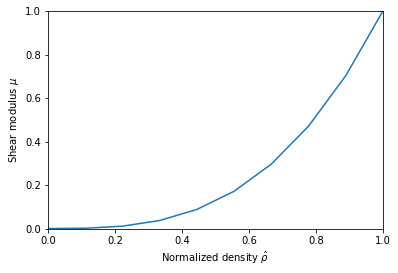

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Material parameters
p=3
mu0 = 1.0
lbd0 = 1.0

# Definition of the material model
def stress(eps, rho_hat):
    from skfem.helpers import trace, eye
    mu = mu0 * rho_hat**p 
    lbd = lbd0 * rho_hat**p 
    return 2.0 * mu * eps + lbd * eye(trace(eps), eps.shape[0])

# Plot the SIMP relation
rho_hat_plot = np.linspace(0,1,10)
plt.plot(rho_hat_plot, mu0 * rho_hat_plot**p)
plt.xlabel(r"Normalized density $\hat{\rho}$")
plt.ylabel(r"Shear modulus $\mu$")
plt.xlim([0, 1])
plt.ylim([0, mu0])
plt.show()


## Weak form of the momentum equation



The weak form of the momentum balance is 

$\int_\Omega \sigma(\textrm{symgrad}(u)) \cdot \textrm{symgrad}(v) dV = f \int_{\partial \Omega} v \cdot n dA$

In [2]:
import skfem as fem

@fem.BilinearForm
def momentum_flux(u, v, w):
    from skfem.helpers import ddot, sym_grad
    return ddot(stress(sym_grad(u), w.rho), sym_grad(v))

@fem.LinearForm
def loading(v, w):
    from skfem.helpers import dot
    return dot(w.n, v)

## Finite element mesh 
Create a finite element mesh with quadratic isoparametric elements. The parameter 'refinements' defines, how often the square domain should be subdivided into smaller elements. A value of 0 results in a single element and a value of 1 results in four elements, because the square is subdivided in two parts in each direction x and y. A value of 2 results in 16 elements, 3 in 81 and so on...
The parameter 'order' is the order of the element shape functions - it can be 1 or 2.

In [3]:
# Mesh parameters 
refinements = 4
order = 1

if order == 1:
    mesh = fem.mesh.MeshQuad1().refined(refinements)
    e_type = fem.ElementQuad1()
elif order == 2:
    mesh = fem.mesh.MeshQuad2().refined(refinements)
    e_type = fem.ElementQuad2()
mesh = mesh.with_boundaries({"top": lambda x : x[1] == 1})

mapping = fem.MappingIsoparametric(mesh, e_type)
e = fem.ElementVector(e_type, 2)
basis = fem.Basis(mesh, e, mapping)
basis0 = basis.with_element(fem.ElementQuad0())

## Boundary conditions

In [4]:
load_basis = fem.FacetBasis(mesh, e, facets=mesh.boundaries["top"])

dofs = {'left' : basis.get_dofs(lambda x: x[0] == 0.0)}
u0 = basis.zeros()
I = basis.complement_dofs(dofs)

# Load at top.
f = 10.0

## Target function for topology optimization

In [5]:
def target_function(design):
    # Assembly
    K = fem.asm(momentum_flux, basis, rho=basis0.interpolate(design))
    B = f  * fem.asm(loading, load_basis)

    # Solution
    u = fem.solve(*fem.condense(K, B, x=u0, I=I))
    
    # Evaluation of strain energy
    return 0.5 * (u @ K @ u)

## Optimization

/Users/nilsmeyer/.pyenv/versions/3.9.2/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Success state:True
Iterations: 60
Solver message: `gtol` termination condition is satisfied.


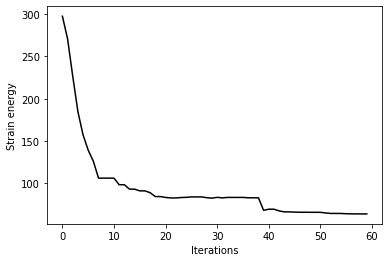

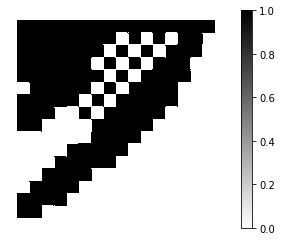

In [6]:
from skfem.visuals.matplotlib import plot
from scipy.optimize import minimize

# Volume constraint parameter
vol_constraint = 0.5

# Number of elements
N = basis.nelems
# Initial guess is a homogeneous distribution 
rho0 = vol_constraint * np.ones(N)
# The design variables are limited to the range 0 to 1
bounds = N*[(0.0, 1.0)]
# The inequality constraint limits the maximum volume occupied by filled material
constraints = {'type':'ineq', 'fun': lambda x : vol_constraint*N-np.sum(x)}
hess = lambda x: np.zeros((N, N))
# Increase the maximum allowed iterations for the solver
options = {"maxiter": 100}
# Save functions values during optimization for plotting
energies = []
def callback(x, state):
    energies.append(state.fun)

# Run the actual optimization
res = minimize(target_function, rho0, method="trust-constr", constraints=constraints, bounds=bounds, options=options, hess=hess, callback=callback)
print(f"Success state:{res.success}")
print(f"Iterations: {res.nit}")
print(f"Solver message: {res.message}")

# Plot the optimization convergence
plt.plot(energies, "-k")
plt.xlabel("Iterations")
plt.ylabel("Strain energy")
plt.show()

# plot the resulting material distribution
plot(mesh, res.x, cmap=plt.cm.binary, colorbar=True, vmin=0, vmax=1.0)
plt.show()